<H1><B>Importing Libraries</B></H1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd

<H1><B>Function to load the image</B></H1>

In [2]:
def load_image(img_path):
    img = Image.open(img_path)
    # Converting to greyscale image
    img = img.convert('L')
    # Converting the PIL image to a NumPy array
    img_array=np.array(img)
    return img_array

<H1><B>Function to Find Light points in the image</B></H1>

In [3]:
def find_points(img_array):
    light_points = np.argwhere(img_array >= 220)
    return light_points

<H1><B>Function to prompt user for image path</B></H1>

In [4]:
def get_image():
    return input("Enter the path of the image: ")

<H1><B>Function to read and print the image from the user input image path</B></H1>

In [5]:
def read_image():
    image_path = get_image()
    image_data = load_image(image_path)
    
    # Show the imported image
    plt.imshow(image_data, cmap='gray')
    plt.title('Imported Image')
    plt.axis('off')
    plt.show()
    return image_data

<H1><B>Printing the image captured</B></H1>

Enter the path of the image:  /Users/mauryavardhansingh/Downloads/2.png


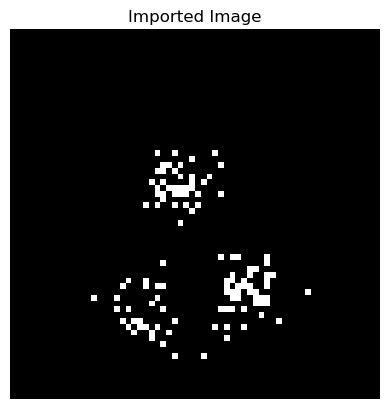

In [6]:
image_data = read_image()

<H1><B>Function to Calculate Distance between two points</B></H1>

In [7]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1-p2)**2))

<H1><B>Function to find the Best Centroids by running K-Means Multiple times</B></H1>

In [8]:
def k_means(data, k, max_iters=100, tol=1e-4, runs=10):
    best_wcss = float('inf')
    best_centroids = None
    best_labels = None
    
    for _ in range(runs):
        centroids, labels = k_means_single_run(data, k, max_iters, tol)
        wcss_value = wcss(data, centroids, labels)
        if wcss_value < best_wcss:
            best_wcss = wcss_value
            best_centroids = centroids
            best_labels = labels

    return best_centroids, best_labels

<H1><B>Function to perform K-Means Clustering</B></H1>

In [9]:
def k_means_single_run(data, k, max_iters=100, tol=1e-4):
    # Randomly select k (x, y) coordinates within the image dimensions
    random_indices = np.random.choice(data.shape[0], size=k, replace=False)

    # Select the corresponding centroids from random points
    centroids = data[random_indices]

    # Loop until convergence of centroids
    for _ in range(max_iters):
        
        # Calculating distances of all data points from each centroid
        dist = []
        
        for d in data:
            distances_to_centroids = [distance(d, centroid) for centroid in centroids]
            dist.append(distances_to_centroids)
            
        dist=np.array(dist)
        
        # Assigning Data points/Clusters to nearest centroids
        labels = np.argmin(dist, axis=1) #selecting indices of minimum distance along each row of "dist" numpy array

        # Updating Centroids
        new_centroids = []
        
        for i in range(k):
            cluster_points = data[labels == i] #Selecting the cluster points of each centroid
            if len(cluster_points) > 0:
                new_centroid = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, reinitialize centroid to a new random point
                new_centroid = data[np.random.choice(data.shape[0])]
            new_centroids.append(new_centroid)
        
        new_centroids = np.array(new_centroids)

        # Convergence Check of centroids
        if np.allclose(new_centroids, centroids, atol=tol):
            break

        centroids=new_centroids

    return centroids, labels

<H1><B>Function to calculate Within-Cluster Sum Of Squares of Cluster points from corresponding Centroids</B></H1>

In [10]:
def wcss(data, centroids, labels):
    Wcss=0
    for index1, centroid in enumerate(centroids): #Traversing elemnents along with indices of centroids numpy array
        points=[] #Selecting cluster points of corresponding centroids
        for index, values in enumerate(data):
            if labels[index]==index1: 
                points.append(values)
        points=np.array(points)
        for point in points:
            Wcss+=(np.sqrt(np.sum((point-centroid)**2)))
    return Wcss

<H1><B>Function to plot the graph of WCSS values vs K</B></H1>

In [11]:
def graph(wcss_list):
    plt.plot(range(1,11), wcss_list, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title('Elbow Method')
    plt.grid(True)
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.show()

<H1><B>Function to calculate optimal no of clusters using elbow method</B></H1>

In [12]:
def elbow(data):
    wcss_list=[]
    
    for k in range(1, 11):
        centroids, labels= k_means(data, k)
        Wcss=wcss(data, centroids, labels)
        wcss_list.append(Wcss)

    
    #Algorithm to find the value of k at which the slope of the graph decreases suddenly
    first_derivative = np.diff(wcss_list)
    second_derivative = np.diff(first_derivative)
    
    # Find the point with the maximum second derivative
    elbow_point = np.argmax(second_derivative) + 2 #Adding 2 because taking diffrence 2 times reduces the index by 2

    return elbow_point, wcss_list

<H1><B>Function to run the program</B></H1>

In [13]:
#Finding Points where there is light
light_points=find_points(image_data)

#Calulating optimal value of k and corresponding wcss values
k, wcss_list=elbow(light_points)

# Applying k means clustering with appropriate k
centroids, labels= k_means(light_points, k)

<H1><B>Plotting the graph of WCSS values vs K</B></H1>

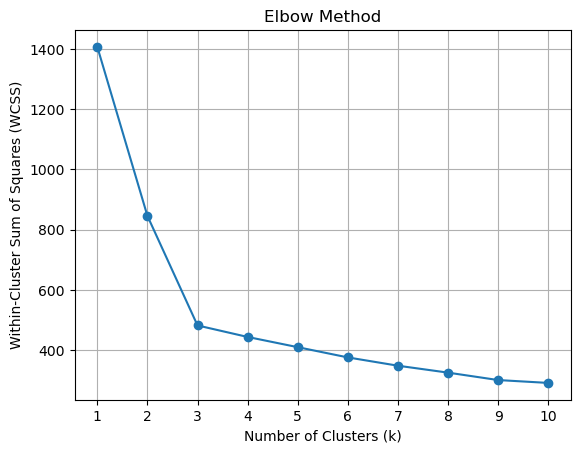

Optimal value of k from the graph is: 3


In [14]:
graph(wcss_list)
print(f"Optimal value of k from the graph is: {k}")

<H1><B>Plotting Cities with different colors</B></H1>

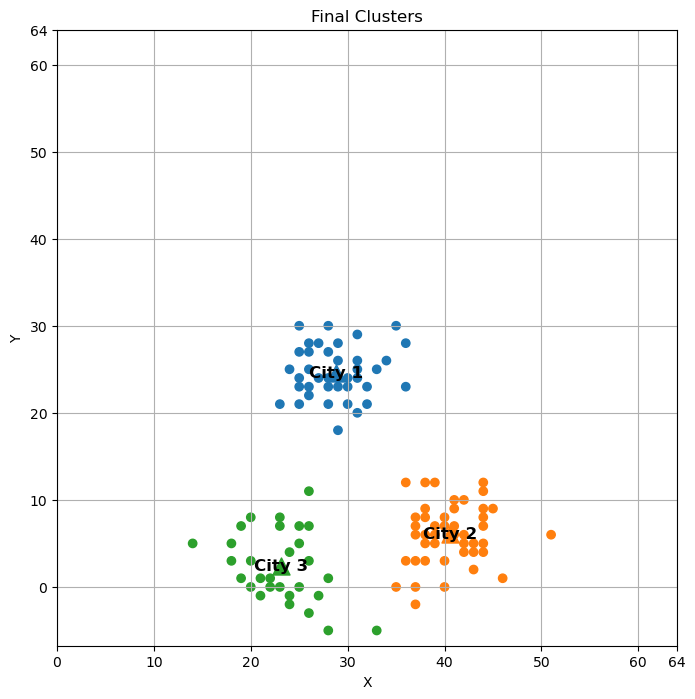

In [15]:
# Color map for clusters
colmap = {i: plt.cm.tab10(i) for i in range(k)}

# Creating a DataFrame for light points
df = pd.DataFrame(light_points, columns=['x', 'y'])

# Adding labels to DataFrame
df['labels'] = labels

# Map colors to clusters
df['color'] = df['labels'].map(lambda x: colmap[x])

# Get the maximum y value to invert coordinates properly
max_y = df['y'].max()

# Rotate points by 90 degrees clockwise
df['x_rot'] = df['y']
df['y_rot'] = max_y - df['x']

# Plotting the clusters
plt.figure(figsize=(8, 8))
plt.scatter(df['x_rot'], df['y_rot'], color=df['color'], alpha=1)

# Rotate centroids by 90 degrees clockwise
for i, centroid in enumerate(centroids):
    centroid_x_rot = centroid[1]
    centroid_y_rot = max_y - centroid[0]
    plt.scatter(centroid_x_rot, centroid_y_rot, color=colmap[i], marker='^', s=150)
    plt.text(centroid_x_rot, centroid_y_rot, f'City {i+1}', fontsize=12, fontweight='bold', ha='center', va='center')

plt.title('Final Clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.xticks([0,10,20,30,40,50,60,64])
plt.yticks([0,10,20,30,40,50,60,64])
plt.show()

<H1><B>Final Ouptut of the program</B></H1>

In [16]:
# Calculating Distances between the centroids of the clusters
distances=np.array([[distance(centroids[i], centroids[j]) for j in range(k)] for i in range(k)])

distance1=distances.shape[0]

# Final Output
print("Distances between centroids (clusters):")
for i in range(distance1):
    for j in range(i+1, distance1):
        print(f"City {i+1} and City {j+1} is {distances[i][j]:.2f}")

Distances between centroids (clusters):
City 1 and City 2 is 21.92
City 1 and City 3 is 22.96
City 2 and City 3 is 17.83
